### CNN
* http://andrew.gibiansky.com/blog/machine-learning/convolutional-neural-networks/
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721
* https://algotravelling.com/ru/%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5-%D1%8D%D1%82%D0%BE-%D0%B2%D0%B5%D1%81%D0%B5%D0%BB%D0%BE-3/
* https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
* https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b
* https://github.com/udsclub/images-classification-caltech
* https://www.asozykin.ru/courses/nnpython

### Preprocessing
* https://www.embedded-vision.com/sites/default/files/apress/computervisionmetrics/chapter2/9781430259299_Ch02.pdf
* https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network
* https://www.quora.com/What-are-some-ways-of-pre-procesing-images-before-applying-convolutional-neural-networks-for-the-task-of-image-classification
* http://cs231n.github.io/neural-networks-2/#datapre
* http://www.robots.ox.ac.uk/~vgg/practicals/cnn/#getting-started
* https://www.safaribooksonline.com/library/view/programming-computer-vision/9781449341916/ch01.html
* https://stackoverflow.com/a/10169025/5151861
* augmentation tf+keras http://machinelearningmastery.com/image-augmentation-deep-learning-keras/

#### Augmentation
* rotation: random with angle between 0° and 360° (uniform)
* translation: random with shift between -10 and 10 pixels (uniform)
* rescaling: random with scale factor between 1/1.6 and 1.6 (log-uniform)
* flipping: yes or no (bernoulli)
* shearing: random with angle between -20° and 20° (uniform)
* stretching: random with stretch factor between 1/1.3 and 1.3 (log-uniform)
* whitening
* https://www.tensorflow.org/api_docs/python/tf/image
* https://github.com/aleju/imgaug
* http://augmentor.readthedocs.io/en/master/
* https://github.com/analysiscenter/dataset

* uint8 0 to 255
* uint16 0 to 65535
* uint32 0 to 232
* float -1 to 1 or 0 to 1
* int8 -128 to 127
* int16 -32768 to 32767
* int32-231 to 231 - 1

* Gaussian blurring of images
* Morphology—Counting Objects

Ресайзинг - важно
* http://ufldl.stanford.edu/wiki/index.php/UFLDL_Tutorial

* одну- дву- слойную cnn
* графики ошибки
* 224х224
* 32х32
* в керас
* серые картинки 
* тензор борд
* презентация по аугментации

In [1]:
from scipy import ndimage
import numpy as np
import pandas as pd
import os
from IPython.display import display, Image
from scipy import misc
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
pixel_depth = 255.0 # number of levels per pixel
num_classes = 257 # number of total classes
test_folder = 'data/test' # dir, where test set is placed
train_folder = 'data/train' # dir, where train set is placed

In [3]:
def reshape(img):
    nsamples, nx, ny = img.shape
    return img.reshape((nsamples,nx*ny))

In [4]:
def load_test_set():
    num_images = 0
    images = os.listdir(test_folder)
    test_set = []
    for image in images:
        image = os.path.join(test_folder, image)
        test_set.append(io.imread(image))
    return test_set

In [ ]:
test_set = load_test_set()

In [ ]:
len(train_metadata)

In [5]:
%%time
dir_train = 'data/train'
train_df = pd.DataFrame(columns = ['category', 'image_name', 'width', 'height', 'type', 'target'])
folders = os.listdir(dir_train)
for ind, folder in enumerate(folders):
    if ind % 30 == 0:
        print('{}'.format(folder))
    folder = os.path.join(train_folder, folder)
    if os.path.isdir(folder):
        image_files = os.listdir(folder)
        for image_file in image_files:
            if not image_file.startswith('.'):
                image = misc.imread(os.path.join(folder, image_file))
                category = folder[15:]
                width = image.shape[0]
                height = image.shape[1]
                #target = folder.split('.')[0].split('/')[2]
                target = int(folder.split('.')[0].split('/')[2])
                train_df.loc[train_df.shape[0]]=[category, image_file, width, 
                                                 height, image.dtype, target]

.DS_Store
030.canoe
060.duck
090.gorilla
120.joy-stick
150.octopus
180.screwdriver
210.syringe
240.watch-101
CPU times: user 6min 2s, sys: 22.6 s, total: 6min 25s
Wall time: 7min 5s


In [6]:
train_df.to_csv('data/train_df.csv')

### Classes distribution

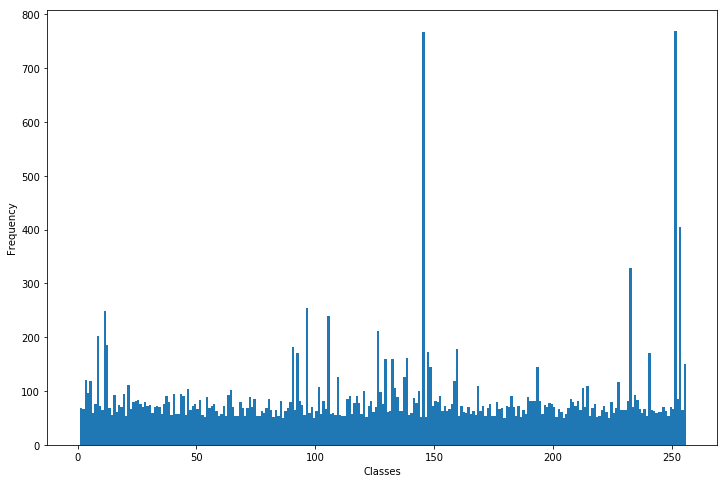

In [7]:
plt.figure(figsize=(12, 8))
plt.hist(train_df['target'], bins=range(len(train_df['target'].unique())))
plt.xlabel('Classes')
plt.ylabel('Frequency');

In [8]:
train_df = pd.read_csv('data/train_df.csv', index_col=0)

In [10]:
y = train_df['target']
X = train_df.copy()
X.drop('target', axis=1, inplace=True)

In [15]:
X.to_csv('data/train_features')
y.to_csv('data/train_target')

In [16]:
def check_dir(directory):
    if not os.path.exists(directory):
        create_dir(directory)

In [17]:
def create_dir(directory):
    os.makedirs(directory)

In [18]:
def norm(img):
    return img / 255.0

In [38]:
dir_train_transformed = 'data/train_transformed'
dir_train = 'data/train'
img_size=(64, 64)
    
check_dir(dir_train_transformed)
folders = os.listdir(dir_train)
for ind, folder in enumerate(folders):
        subfolder = os.path.join(dir_train, folder)
        if os.path.isdir(subfolder):
            if ind % 30 == 0:
                print('{}'.format(folder))
            for image_file in os.listdir(subfolder):
                if not image_file.startswith('.'):
                    name = os.path.join(subfolder, image_file)
                    image = misc.imread(name)
                    if len(image.shape) == 2:
                        image = np.stack((image,)*3)
                    image = misc.imresize(image, img_size, interp='bicubic')
                    #image = norm(image)
                    fold_to_save = os.path.join(dir_train_transformed, image_file)
                    misc.imsave(fold_to_save, image)

030.canoe
060.duck
090.gorilla
120.joy-stick
150.octopus
180.screwdriver
210.syringe
240.watch-101


In [21]:
%%time
# load data in flattened form

dir_train_transformed = 'data/train_transformed'
# img parameters
img_shape = (64, 64)
channels = 3
img_shape_flattened = img_shape[0] * img_shape[1] * channels
img_qty = train_df.shape[0]

# initialize X,y
X = np.empty(shape=(img_qty, img_shape_flattened), dtype=np.int8)
y = np.empty(shape=(img_qty,), dtype=np.uint16)

# read images
for i,f_name in enumerate(os.listdir(dir_train_transformed)):
    if i % 5000 == 0:
        print('{:6d}/{:6d} images loaded'.format(i, img_qty))
    
    img_path = os.path.join(dir_train_transformed, f_name)
    X[i, :] = misc.imread(img_path).flatten('C') # since img is np.ndarray, flatten in row-style
    y[i] = train_df.loc[train_df['image_name'] == f_name, 'target'].iloc[0]

     0/ 22897 images loaded
  5000/ 22897 images loaded
 10000/ 22897 images loaded
 15000/ 22897 images loaded
 20000/ 22897 images loaded
CPU times: user 1min 15s, sys: 3.99 s, total: 1min 19s
Wall time: 1min 28s


In [39]:
X_train, X_test, y_train, t_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [40]:
from sklearn.linear_model import LogisticRegression  # baseline classifier
from sklearn.decomposition import PCA # to reduce training columns
from sklearn.pipeline import Pipeline # to "glue" model steps/components together
from sklearn.metrics import accuracy_score # to test quality of the classifier
from sklearn.preprocessing import StandardScaler

### Find optimal PCA components

In [ ]:
pca = PCA(n_components=2000).fit(X_train)
print('{}'.format(np.cumsum(pca.explained_variance_ratio_)))

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')

In [24]:
pca = PCA(n_components=2000, random_state=42)
svc = LogisticRegression(random_state=42, C=0.1, max_iter=50, verbose=2, n_jobs=-1, class_weight='balanced')
scaler = StandardScaler()

model = Pipeline((('scaler', scaler), ('dim_reduction', pca), ('classifier', svc)))

In [25]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [ ]:
svc.fit(X_train_pca, y_train)

In [ ]:
accuracy(X_train, y_train)
accuracy(X_test, y_test)

In [ ]:
y_pred = svc.predict(X_test)

sub = pd.DataFrame(
    data=[row for row in zip(os.list.dir(dir_test_transformed), y_pred.astype(int).tolist)],
    columns=['image', 'class']
)

In [ ]:
def accuracy(X, y):
    print('accuracy: {}'.forma(accuracy_score(y, model.predict(X))))

In [ ]:
%%time
dir_test_transformed = 'data/test_transformed'
img_size=(64, 64)
check_dir(dir_test_transformed)
folders = os.listdir(dir_test_transformed)
for ind, folder in enumerate(folders):
        subfolder = os.path.join(train_folder, folder)
        if os.path.isdir(subfolder):
            if ind % 30 == 0:
                print('{}'.format(folder))
            for image_file in os.listdir(subfolder):
                if not image_file.startswith('.'):
                    name = os.path.join(subfolder, image_file)
                    image = misc.imread(name)
                    if len(image.shape) == 2:
                        image = np.stack((image,)*3)
                    image = misc.imresize(image, img_size, interp='bicubic')
                    #image = norm(image)
                    fold_to_save = os.path.join(transform_folder, image_file)
                    misc.imsave(fold_to_save, image)

In [ ]:
%%time
# load data in flattened form

# img parameters
dir_test_transformed = 'data/test_transformed'
img_shape_flattened = img_shape[0] * img_shape[1] * channels
img_qty = train_df.shape[0]

# initialize X,y
X_test = np.empty(shape=(img_qty, img_shape_flattened), dtype=np.int8)

# read images
for i,f_name in enumerate(os.listdir(dir_test_transformed)):
    if i % 5000 == 0:
        print('{:6d}/{:6d} images loaded'.format(i, img_qty))
    
    img_path = os.path.join(dir_train_transformed, f_name)
    X[i, :] = misc.imread(img_path).flatten('C') # since img is np.ndarray, flatten in row-style